date: Aug 2020

# Task

__Background:__ Our company creates data science content for consumption.

__Task:__ What is "best" content to write about?

__Definition:__ "Best" is whatever that people want to learn about in data science.

__Approach:__ Analyze datascience.stackexchange.com to see what people are most wanting to learn about.

__Cursory findings:__

* The top 5 most popular tags are `machine-learning`, `python`, `neural-network`, `deep-learning`, and `classification`
* Front page questions are about the specifics of various deep learning techniques
* Each post typically provides the poster's current task, a description of their dataset, and their goal

Stack exchange provides a query page for investigating their database via SQL: https://data.stackexchange.com/datascience/query/edit/1277805

The relevant tables are:

* Posts
* Comments
* Tags
* TagSynonyms
* Votes
* VoteTypes

An investigation of these tables may provide some guidance into what the most popular content is in the datascience stackexchange.

To filter the `Posts` table to only 2019 posts, the following SQL query was used:

```sqlite
SELECT Id, PostTypeId, CreationDate, Score, 
       ViewCount, Tags, AnswerCount,FavoriteCount
FROM Posts
WHERE CreationDate >= '20190101' AND CreationDate < '20200101';
```

The result was saved as a `.csv` file and imported.

# Clean

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('2019_questions.csv')

In [3]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8839 non-null   int64  
 1   CreationDate   8839 non-null   object 
 2   Score          8839 non-null   int64  
 3   ViewCount      8839 non-null   int64  
 4   Tags           8839 non-null   object 
 5   AnswerCount    8839 non-null   int64  
 6   FavoriteCount  1407 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 483.5+ KB


There are no missing values except in the `FavoriteCount` column. This cannot be fixed. The `Tags` column are strings with multiple tags per post. This can be cleaned.

In [5]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [7]:
df = df.fillna(0)

In [8]:
df['Tags'] = df['Tags'].str.replace('>',',')
df['Tags'] = df['Tags'].str.replace('<','')
df['Tags'] = df['Tags'].str.strip(',')
df['Tags'] = df['Tags'].str.split(',')

In [9]:
df.head(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0.0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0.0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0.0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0.0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0.0


# Analysis

In [10]:
df = df.loc[1:,:]

Note: The first row was bugged, the `Tags` cell contains an infinite list of lists of lists of ... and so was removed.

In [11]:
list_col = df['Tags'].values
new_list = []
index_list = []
count_list = []

for i in range(len(list_col)):
    new_list.extend(list_col[i])
    index_list.extend([i]*len(list_col[i]))
    count_list.extend([j for j in range(len(list_col[i]))])

df2 = pd.merge(df.drop("Tags",axis=1),
               pd.DataFrame({"Tags":new_list,
                             "Tags_num":count_list},
                            index=index_list),
               how = 'left',
               left_index=True,right_index=True).reset_index(drop=True)

[Source](https://stackoverflow.com/questions/27263805/pandas-column-of-lists-create-a-row-for-each-list-element) for technique

In [12]:
df2.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,FavoriteCount,Tags,Tags_num
0,44420,2019-01-23 09:34:01,0,25,0,0.0,python,0.0
1,44420,2019-01-23 09:34:01,0,25,0,0.0,time-series,1.0
2,44420,2019-01-23 09:34:01,0,25,0,0.0,forecast,2.0
3,44420,2019-01-23 09:34:01,0,25,0,0.0,forecasting,3.0
4,44423,2019-01-23 09:58:41,2,1651,0,0.0,machine-learning,0.0


In [13]:
new_df = df2[['Id','ViewCount','Tags']]

In [14]:
new_df.head()

,Id,ViewCount,Tags
0,44420,25,python
1,44420,25,time-series
2,44420,25,forecast
3,44420,25,forecasting
4,44423,1651,machine-learning


## How many times was each tag used

In [15]:
view_df = new_df['Tags'].value_counts()
view_df.head()

machine-learning    2691
python              1814
deep-learning       1220
neural-network      1055
keras                935
Name: Tags, dtype: int64

The top 10 `Tags` are all related to machine-learning topics, with the top `Tag` being machine-learning itself.

## How many times was each tag viewed

In [16]:
sum_df = new_df.groupby('Tags').sum().sort_values('ViewCount',ascending=False)[['ViewCount']]
sum_df.head()

,ViewCount
Tags,
machine-learning,502671
python,283486
deep-learning,236941
neural-network,228587
keras,168797


The most used tags tended to be the most viewed as well.

In [17]:
sum_view = pd.merge(sum_df.reset_index(),view_df.reset_index(), 
         left_on='Tags',
         right_on='index')
sum_view = sum_view[['Tags_x','ViewCount','Tags_y']]
sum_view.columns = ['Tags','Views','Occurrence']
sum_view.head()

,Tags,Views,Occurrence
0,machine-learning,502671,2691
1,python,283486,1814
2,deep-learning,236941,1220
3,neural-network,228587,1055
4,keras,168797,935


In [18]:
sum_view[['Views','Occurrence']].corr()

,Views,Occurrence
Views,1.000000,0.983175
Occurrence,0.983175,1.000000


Our observation is backed up by correlation, there is a +0.98 Pearson coefficient for the number of views x number of times the tag was used.

## Visualization of top tags

Text(0, 0.5, 'Number of times used')

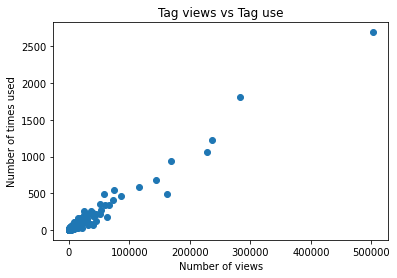

In [19]:
%matplotlib inline
plt.scatter('Views','Occurrence',data = sum_view)
plt.title('Tag views vs Tag use')
plt.xlabel('Number of views')
plt.ylabel('Number of times used')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'machine-learning'),
  Text(1, 0, 'python'),
  Text(2, 0, 'deep-learning'),
  Text(3, 0, 'neural-network'),
  Text(4, 0, 'keras'),
  Text(5, 0, 'classification'),
  Text(6, 0, 'tensorflow'),
  Text(7, 0, 'scikit-learn'),
  Text(8, 0, 'nlp'),
  Text(9, 0, 'cnn')])

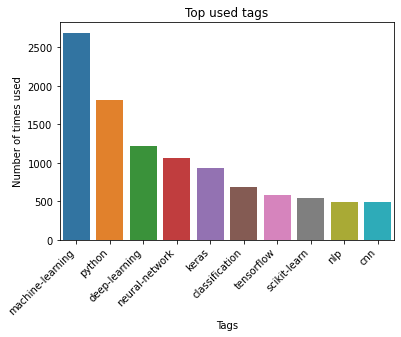

In [20]:
sns.barplot('Tags','Occurrence',data=sum_view.sort_values('Occurrence',ascending=False).head(10))
plt.title('Top used tags')
plt.ylabel('Number of times used')
plt.xticks(rotation=45,horizontalalignment='right')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'machine-learning'),
  Text(1, 0, 'python'),
  Text(2, 0, 'deep-learning'),
  Text(3, 0, 'neural-network'),
  Text(4, 0, 'keras'),
  Text(5, 0, 'cnn'),
  Text(6, 0, 'classification'),
  Text(7, 0, 'tensorflow'),
  Text(8, 0, 'time-series'),
  Text(9, 0, 'scikit-learn')])

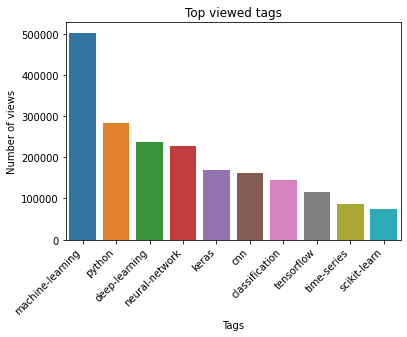

In [21]:
sns.barplot('Tags','Views',data=sum_view.sort_values('Views',ascending=False).head(10))
plt.title('Top viewed tags')
plt.ylabel('Number of views')
plt.xticks(rotation=45,horizontalalignment='right')

The tag `machine-learning` is by far the most used and viewed tag, approximately 2x as much than the next top tag `python`. 

## Relationships

__Question:__ What tags are used most often together?

In [22]:
df[df["Tags"].apply(
    lambda tags: True if "machine-learning" in tags and "r" in tags else False)
]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
172,55818,2019-07-17 08:00:00,0,50,"[machine-learning, r, feature-engineering, dat...",0,1.0
197,55867,2019-07-17 21:24:42,0,12,"[machine-learning, r, association-rules]",0,0.0
403,56141,2019-07-22 09:26:29,0,23,"[machine-learning, neural-network, deep-learni...",0,0.0
613,45121,2019-02-05 20:57:25,2,61,"[machine-learning, python, r, machine-learning...",1,0.0
1093,46003,2019-02-22 08:12:46,1,112,"[machine-learning, r, data-science-model]",1,0.0
...,...,...,...,...,...,...,...
7549,64722,2019-12-12 21:21:58,0,21,"[machine-learning, r, regression]",0,0.0
7621,64886,2019-12-15 18:49:41,1,32,"[machine-learning, neural-network, r, xgboost,...",0,0.0
7976,54645,2019-06-27 21:29:20,0,16,"[machine-learning, python, r, anomaly-detectio...",0,0.0
8333,65638,2019-12-30 15:22:22,1,30,"[machine-learning, r, algorithms]",0,0.0


In [23]:
df['num_tags'] = df['Tags'].apply(lambda x: len(x))
df['num_tags'].unique()

array([4, 3, 1, 2, 5])

Text(0, 0.5, 'Number of views')

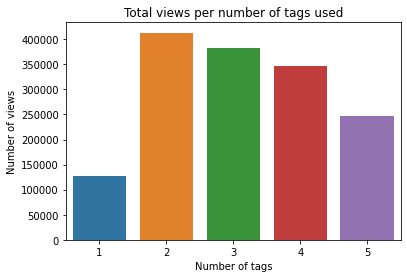

In [24]:
sns.barplot('num_tags','ViewCount',
        data=df.groupby('num_tags').sum()[['ViewCount']].reset_index())
plt.title('Total views per number of tags used')
plt.xlabel('Number of tags')
plt.ylabel('Number of views')

The number of tags per post does not exceed 5, and the most viewed posts have tags < 5 but > 1

In [25]:
sum_view = sum_view.sort_values('Views',ascending=False).reset_index(drop=True)

In [26]:
# limit the tags to only the top 20 most viewed ones
tags_list = list(sum_view.iloc[:20]['Tags'])

In [27]:
corr_df = pd.DataFrame(columns=tags_list, index=tags_list)
corr_df = corr_df.fillna(0)

In [28]:
for row in df['Tags']:
    for i in row:
        for x in row:
            try:
                corr_df.loc[i,x] += 1
            except:
                pass

In [29]:
corr_df.sort_values('machine-learning',ascending=False)

,machine-learning,python,deep-learning,neural-network,keras,cnn,classification,tensorflow,time-series,scikit-learn,lstm,regression,pytorch,dataset,nlp,r,image-classification,pandas,computer-vision,data-mining
machine-learning,2692,499,429,366,195,124,259,106,131,188,71,119,25,99,113,63,68,62,38,94
python,499,1814,160,137,280,62,98,167,105,235,61,59,41,53,71,24,24,244,22,27
deep-learning,429,160,1220,305,247,160,59,136,44,16,103,21,41,32,72,5,66,1,55,24
neural-network,366,137,305,1055,235,118,65,108,33,24,69,42,26,20,24,9,49,1,10,4
classification,259,98,59,65,58,20,685,20,25,47,20,34,2,28,35,10,16,3,7,19
keras,195,280,247,235,935,116,58,256,51,34,133,31,12,13,23,10,46,3,11,1
scikit-learn,188,235,16,24,34,0,47,15,12,540,2,37,2,9,12,1,1,37,0,2
time-series,131,105,44,33,51,8,25,9,466,12,87,24,3,6,0,22,0,19,0,11
cnn,124,62,160,118,116,489,20,57,8,0,24,6,19,11,7,2,67,1,14,2
regression,119,59,21,42,31,6,34,9,24,37,11,347,4,6,2,10,1,6,1,3


In [30]:
for col in list(corr_df.columns):
    corr_df[col] = 100*(corr_df[col]/corr_df[col].sum())

Text(0.5, 1.0, '% of times each tag occurs with the other')

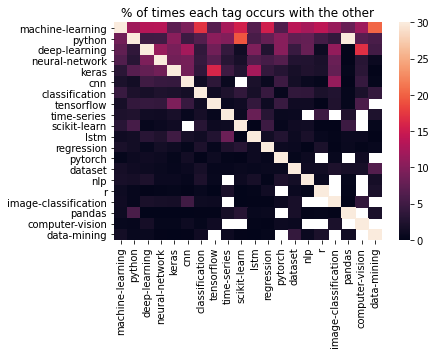

In [33]:
sns.heatmap(corr_df[corr_df>0].dropna(how='all'),0,30,annot=False)
plt.title('% of times each tag occurs with the other')

## Is deep learning a fad?

Is machine/deep learning just a fad? To answer the question we can look at the tag's use over time.

In [34]:
df_q = pd.read_csv('all_questions.csv')

In [35]:
df_q['CreationDate'] = pd.to_datetime(df_q['CreationDate'])
df_q['Tags'] = df_q['Tags'].str.replace('>',',')
df_q['Tags'] = df_q['Tags'].str.replace('<','')
df_q['Tags'] = df_q['Tags'].str.strip(',')
df_q['Tags'] = df_q['Tags'].str.split(',')

In [36]:
df_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            21576 non-null  int64         
 1   CreationDate  21576 non-null  datetime64[ns]
 2   Tags          21576 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


In [37]:
df_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In [38]:
df_q['CreationDate'].dt.year.unique()

array([2019, 2014, 2018, 2017, 2016, 2015, 2020])

In [39]:
df_q[df_q['CreationDate'] > '20200101']

,Id,CreationDate,Tags
20304,65678,2020-01-01 01:07:22,"[machine-learning, deep-learning, data-mining,..."
20305,65680,2020-01-01 07:53:47,"[python, k-means, image-segmentation]"
20306,65684,2020-01-01 11:27:44,"[r, random-forest, bigdata]"
20307,65686,2020-01-01 13:56:11,"[computer-vision, image-recognition, vae]"
20308,65688,2020-01-01 16:17:40,"[machine-learning, neural-network, deep-learni..."
...,...,...,...
21320,66684,2020-01-18 21:17:34,"[machine-learning, python, matplotlib, csv]"
21321,66685,2020-01-18 23:56:27,"[machine-learning, nlp, named-entity-recognition]"
21322,66686,2020-01-19 00:49:00,"[data-mining, bigdata, association-rules]"
21323,66690,2020-01-19 02:21:53,"[keras, gan]"


2020 is removed from analysis as the most recent data is up to January 2020 and does not reflect a full year.

In [40]:
df_q = df_q[df_q['CreationDate'] < '20200101'].copy()

In [41]:
df_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In [42]:
sum_view[sum_view['Views'] > 10000]

,Tags,Views,Occurrence
0,machine-learning,502671,2691
1,python,283486,1814
2,deep-learning,236941,1220
3,neural-network,228587,1055
4,keras,168797,935
...,...,...,...
84,recommender-system,10555,103
85,normalization,10493,74
86,orange,10393,64
87,text-mining,10384,113


In [43]:
# Deep learning tags from the top 20
dl_map = {
    'deep-learning':'deep-learning',
    'neural-network':'deep-learning',
    'keras':'deep-learning',
    'cnn':'deep-learning',
    'classification':'deep-learning',
    'tensorflow':'deep-learning',
    'scikit-learn':'deep-learning',
    'lstm':'deep-learning',
    'pytorch':'deep-learning',
    'reinforcement-learning':'deep-learning'
}

In [44]:
# in list form
dl_items = list(dl_map.keys())

In [45]:
sum_view['dl'] = sum_view['Tags'].map(dl_map)

In [46]:
list_col = df_q['Tags'].values
new_list = []
index_list = []
count_list = []

for i in range(len(list_col)):
    new_list.extend(list_col[i])
    index_list.extend([i]*len(list_col[i]))
    count_list.extend([j for j in range(len(list_col[i]))])

df_q2 = pd.merge(df_q.drop("Tags",axis=1),
               pd.DataFrame({"Tags":new_list,
                             "Tags_num":count_list},
                            index=index_list),
               how = 'left',
               left_index=True,right_index=True).reset_index(drop=True)

In [47]:
df_q2['dl'] = df_q2['Tags'].map(dl_map)
df_q2['year'] = df_q2['CreationDate'].dt.year

In [48]:
df_q2_dl = df_q2[df_q2['dl']=='deep-learning']

In [49]:
df_q2_dl.groupby(['year','Tags']).count()

Id  CreationDate  Tags_num    dl
year Tags                                                      
2014 classification            73            73        73    73
     deep-learning              8             8         8     8
     neural-network            26            26        26    26
     reinforcement-learning     2             2         2     2
     scikit-learn              14            14        14    14
2015 classification           133           133       133   133
     deep-learning             30            30        30    30
     keras                      2             2         2     2
     neural-network            96            96        96    96
     reinforcement-learning     9             9         9     9
     scikit-learn              43            43        43    43
     tensorflow                 4             4         4     4
2016 classification           204           204       204   204
     cnn                       17            17        17    17
     deep-learning            184           184       184   184
     keras                     61            61        61    61
     lstm                       9             9         9     9
     neural-network           293           293       293   293
     pytorch                    1             1         1     1
     reinforcement-learning    21            21        21    21
     scikit-learn             145           145       145   145
     tensorflow                81            81        81    81
2017 classification           284           284       284   284
     cnn                       31            31        31    31
     deep-learning            425           425       425   425
     keras                    174           174       174   174
     lstm                      41            41        41    41
     neural-network           485           485       485   485
     pytorch                   14            14        14    14
     reinforcement-learning    46            46        46    46
     scikit-learn             183           183       183   183
     tensorflow               172           172       172   172
2018 classification           472           472       472   472
     cnn                      246           246       246   246
     deep-learning            821           821       821   821
     keras                    509           509       509   509
     lstm                     226           226       226   226
     neural-network           877           877       877   877
     pytorch                   36            36        36    36
     reinforcement-learning   122           122       122   122
     scikit-learn             341           341       341   341
     tensorflow               341           341       341   341
2019 classification           682           682       682   682
     cnn                      487           487       487   487
     deep-learning           1216          1216      1216  1216
     keras                    932           932       932   932
     lstm                     401           401       401   401
     neural-network          1054          1054      1054  1054
     pytorch                  175           175       175   175
     reinforcement-learning   202           202       202   202
     scikit-learn             537           537       537   537
     tensorflow               583           583       583   583

The above table shows trends in `deep-learning` keywords over 6 years

In [52]:
df_q2_dl.head()

,Id,CreationDate,Tags,Tags_num,dl,year
1,45416,2019-02-12 00:36:29,keras,1.0,deep-learning,2019
2,45416,2019-02-12 00:36:29,tensorflow,2.0,deep-learning,2019
3,45416,2019-02-12 00:36:29,cnn,3.0,deep-learning,2019
5,45418,2019-02-12 00:50:39,neural-network,0.0,deep-learning,2019
9,45426,2019-02-12 04:51:49,keras,0.0,deep-learning,2019


<AxesSubplot:xlabel='year'>

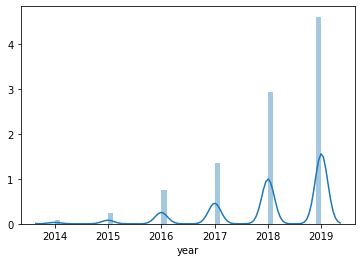

In [76]:
sns.distplot(df_q2_dl['year'])

In [67]:
df_q_count = df_q2_dl.groupby(['year','Tags']).count().reset_index()
df_q_count.head()

,year,Tags,Id,CreationDate,Tags_num,dl
3,2014,reinforcement-learning,2,2,2,2
1,2014,deep-learning,8,8,8,8
4,2014,scikit-learn,14,14,14,14
2,2014,neural-network,26,26,26,26
0,2014,classification,73,73,73,73


In [84]:
hue_order = list(df_q_count[df_q_count['year']==2019].sort_values('Id',ascending=False)['Tags'])

Text(0, 0.5, 'Number of posts')

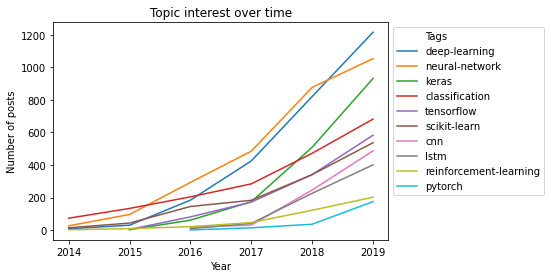

In [85]:
sns.lineplot(x='year',y='Id',hue='Tags',data=df_q_count, hue_order=hue_order)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Topic interest over time')
plt.xlabel('Year')
plt.ylabel('Number of posts')

Deep learning as topic has been gaining interest throughout the years.

Within the `deep-learning` tag, in order of most frequent use in 2019:

1. `deep-learning`
2. `neural-network`
3. `keras`
4. `classification`
5. `tensorflow`
6. `sciki-learn`
7. `cnn`
8. `lstm`
9. `reinforcement-learning`
10. `pytorch`

Regardless of the specific sub-tag, the interest in deep-learning has been accelerating since 2014.

__Recommendation:__ Create content on the topic of deep learning, with a focus on how it's various methods are best used.